<center> <img src = "../figures/hh_label.jpg" width=500, height=300>

# <center> Job seeker's profile analysis form hh.ru

Import all necessary libraries

In [1]:
import pandas as pd
import numpy as np
import plotly.express as px
import plotly.graph_objects as go
import matplotlib.pyplot as plt
import seaborn as sns
import os, re, sys

from sklearn import linear_model
from sklearn import metrics

from sklearn.model_selection import train_test_split
from sklearn import preprocessing

#set path
sys.path.insert(1, '../')
from utils.reader_config import config_reader
config = config_reader('../config/config.json')

# fix random seed
RANDOM_SEED = config.random_seed

from utils.functions import education_level, get_gender,get_age, get_experience

# Data structure study

1) Let us import the dataset and explore the data structure.

In [ ]:
# import gdown # dowload moduld from google drive
# url = "https://drive.google.com/uc?id=1LpReiJ8hQJHbGBiv1Vsp2WDYdO2qaRtA"
# filename = "dst-3.0_16_1_hh_database.zip"
# path = 'data/'
# output = data_zip = os.path.join(path, filename)

# # Создадим папку data, если такой папки нет
# if not os.path.exists("data"):
#     os.mkdir("data")

# gdown.download(url, output=output, quiet=False)

In [2]:
# read the dataset
data = pd.read_csv('../data/dst-3.0_16_1_hh_database.zip', sep=';')

# show two first and two last rows of the DataFrame
display(data.head(1))

# DataFrame size shape
print(f"DataFrame size shape: {data.shape}")

,"Пол, возраст",ЗП,Ищет работу на должность:,"Город, переезд, командировки",Занятость,График,Опыт работы,Последнее/нынешнее место работы,Последняя/нынешняя должность,Образование и ВУЗ,Обновление резюме,Авто
0,"Мужчина , 39 лет , родился 27 ноября 1979",29000 руб.,Системный администратор,"Советск (Калининградская область) , не готов к...","частичная занятость, проектная работа, полная ...","гибкий график, полный день, сменный график, ва...",Опыт работы 16 лет 10 месяцев Август 2010 — п...,"МАОУ ""СОШ № 1 г.Немана""",Системный администратор,Неоконченное высшее образование 2000 Балтийск...,16.04.2019 15:59,Имеется собственный автомобиль


DataFrame size shape: (44744, 12)


2) Let us show all the data frame features and non-null values

In [3]:
# Basic info
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 44744 entries, 0 to 44743
Data columns (total 12 columns):
 #   Column                           Non-Null Count  Dtype 
---  ------                           --------------  ----- 
 0   Пол, возраст                     44744 non-null  object
 1   ЗП                               44744 non-null  object
 2   Ищет работу на должность:        44744 non-null  object
 3   Город, переезд, командировки     44744 non-null  object
 4   Занятость                        44744 non-null  object
 5   График                           44744 non-null  object
 6   Опыт работы                      44576 non-null  object
 7   Последнее/нынешнее место работы  44743 non-null  object
 8   Последняя/нынешняя должность     44742 non-null  object
 9   Образование и ВУЗ                44744 non-null  object
 10  Обновление резюме                44744 non-null  object
 11  Авто                             44744 non-null  object
dtypes: object(12)
memory usage: 4.1+

3) Let us display main statistical information from 

In [4]:
data.describe()

,"Пол, возраст",ЗП,Ищет работу на должность:,"Город, переезд, командировки",Занятость,График,Опыт работы,Последнее/нынешнее место работы,Последняя/нынешняя должность,Образование и ВУЗ,Обновление резюме,Авто
count,44744,44744,44744,44744,44744,44744,44576,44743,44742,44744,44744,44744
unique,16003,690,14929,10063,38,47,44413,30214,16927,40148,18838,2
top,"Мужчина , 32 года , родился 17 сентября 1986",50000 руб.,Системный администратор,"Москва , не готов к переезду , не готов к кома...",полная занятость,полный день,Опыт работы 10 лет 8 месяцев Апрель 2018 — по...,Индивидуальное предпринимательство / частная п...,Системный администратор,Высшее образование 1987 Военный инженерный Кра...,07.05.2019 09:50,Не указано
freq,18,4064,3099,1261,30026,22727,3,935,2062,4,25,32268


# Data transformation and structuring

1) As it might be seen from the table above, the feature entitled  **"Образование и ВУЗ"** contains  user's information of three cathegories, namely: 1) level of education, 2)graduation year 3)university title. In order to simplify the information processing in future, let us split the feature information by separate cathegories respectively. Secondly, let us focus on the level of education, which is always described by three words in the beginning of the string. Finally, the rest (last two) features as well as "Образование и ВУЗ" shall be deleted.

In [5]:
# Apply the function to the DataFrame
data['Education'] = data['Образование и ВУЗ'].apply(education_level) 

# Show the results
display(data['Education'].value_counts())  


# delete the feature 'Образование и ВУЗ'
data.drop(['Образование и ВУЗ'], axis=1, inplace=True)

higher                    33871
secondary_professional     5759
higher_unfinished          4558
secondary                   556
Name: Education, dtype: int64

2. The feature **"Пол, возраст"** also contains three cathegories of user's information: 1)gender 2)age 3)date of birth. Thus, let us pick features 'gender' and 'age and make a distinct colum for each of them. Notably, gender column should be either male or female e.g. 'm' or 'f' cathegories respectively. User age schould be represented by an integer number in years.

In [6]:
# Creation of a new feature 'Gender' 
data['Gender'] = data['Пол, возраст'].apply(get_gender)

# Creation of a new feature 'Age'
data['Age'] = data['Пол, возраст'].apply(get_age)

# User genders rate
print(f"Women rate: {round(data['Gender'].value_counts(normalize=True).loc['F']*100,2)} %")

# Mean user age
print(f"User mean age: {round(data['Age'].mean(),1)} yeaes")

# Delete original feature 
data.drop(['Пол, возраст'], axis=1, inplace=True)

Women rate: 19.07 %
User mean age: 32.2 yeaes


3. The feature  **"Опыт работы"** repersents User Experience is in the following format: <Опыт работы: **n** years **m** months…>. Let us transform its value in months and put it into a new feature 'User_experience'. The original feature "Опыт работы" will be deleted.

In [238]:
       
data["User_experience(months)"] = data['Опыт работы'].apply(get_experience)

# Deleting the original feature 'Опыт работы'
data.drop(['Опыт работы'], axis=1, inplace=True)

#display(data.head(1))

print(f"Mean user experience is: {data['User_experience(months)'].median()} months")

Mean user experience is: 100.0 months


4. The feature  **"Город, переезд, командировки"** contains 3 cathegories of information: 1)city, 2)relocation willingness 3)business trip readiness. The cathegories are separated by comma and are always in oreder explained above.
Let us transfer information into new separate features. As for cities, let us add cathegorization by population: 1)Moscow 2)Petersburg 3)Megapolis 4)other. The list of megapolis cities is shown below:
    
<code><font size = '3'>million_cities = ['Новосибирск', 'Екатеринбург','Нижний Новгород', 'Казань', \
'Челябинск','Омск', 'Самара', 'Ростов-на-Дону', 'Уфа', 'Красноярск', \
'Пермь', 'Воронеж','Волгоград']
</code>

Other two features: relocation willingness and business trip readiness should contain either True or False inputs. At last, let us delete the original feature "Город, переезд, командировки".

In [239]:
def get_city(arg):
    """
   The get_city function return 1 of 4 cathegories of city: 1)Moscow 2)Petersburg 3)Megapolis 4)other. 
   The function argument is a first word of the feature 'Город, переезд, командировки'.
    """
    arg = arg.split(' ') # Method divides the string by spaces

    # The list of megapolis cities
    million_cities = ['Новосибирск', 'Екатеринбург','Нижний Новгород','Казань', \
        'Челябинск','Омск', 'Самара', 'Ростов-на-Дону', 'Уфа', 'Красноярск', \
        'Пермь', 'Воронеж','Волгоград']

    if arg[0] == 'Москва':
        return 'Moscow'
    elif arg[0] == 'Санкт-Петербург':
        return 'Petersburg'
    elif arg[0] in million_cities:
        return 'megapolis'
    else:
        return 'other'

# City cathegorization using the function 'get_city'
data['City'] = data['Город, переезд, командировки'].apply(get_city)

# Definition of relocation willingness
def get_relocation(arg):
    """
    The get_relocation function returns relocation willingness (True/False). The function argument is the feature string 'Город, переезд, командировки'.
    """
    if ('не готов к переезду' in arg) or ('не готова к переезду' in arg): # not ready
        return False 
    elif 'хочу переехать' in arg: # ready
        return True
    else: return True

# relocation willingness using the function 'get_relocation'    
data['Relocation'] = data['Город, переезд, командировки'].apply(get_relocation)


def get_bisiness_trips(arg):
    """
    The get_bisiness_trips function retuens business trip readiness (True/False). The function argument is the feature string 'Город, переезд, командировки'.
    """
    if ('командировка' in arg):
        if ('не готов к командировкам' in arg) or('не готова к командировкам' in arg): # not ready
            return False
        else: 
            
            return True
    else:               # ready
        return False

data['Business_trip'] = data['Город, переезд, командировки'].apply(get_bisiness_trips)

# Share of users living in Petersburg
print(f"Users living in Petersburg share: {round(data[data['City']=='Petersburg']['City'].count()/data['City'].shape[0]*100)} %")

# Share of Users ready for business trips and relocation
print(f"Users ready for business trips and relocation share: {round(data[(data['Relocation']==True) & (data['Business_trip']==True)].shape[0]/data.shape[0]*100)} %")

# Delete the original feature 'Город, переезд, командировки'
data.drop(['Город, переезд, командировки'], axis=1, inplace=True)
#display(data.head(1))

Users living in Petersburg share: 11 %
Users ready for business trips and relocation share: 32 %


5. The feature **"Занятость"** (employment type) has 5 cathegories: full time, part time, project,  volunteering, internship.  The feature  **"График"** (schedule) contains 6 cathegories: full_time, part_time,  flexible, remote, daily_shifts, long_shifts. Let us create separate features for each cathegory which will indicate either True or False. At last, let us delete original features "Занятость" and "График".

In [240]:
# Features for employment type: full time, part time, project,  volunteering, internship.
employment_types = ['полная занятость', 'частичная занятость', 'проектная работа', 'волонтерство', 'стажировка']

for i in employment_types:
    data[i] = data['Занятость'].apply(lambda x: True if i in x else False)

data = data.rename(columns={
    'полная занятость':'full_time', 
    'частичная занятость':'part_time',
    'проектная работа':'project',
    'стажировка':'internship',
    'волонтерство':'volunteering'
})

# Features for schedule types: full_time, flexible, remote, daily_shifts, long_shifts.
schedule =  ['полный день', 'гибкий график', 'удаленная работа', 'сменный график', 'вахтовый метод']

# Features for schedule
for j in schedule:
    data[j] = data['График'].apply(lambda x: True if j in x else False)

data = data.rename(columns={
    'полный день':'full_time',     
    'гибкий график': 'flexible',
    'удаленная работа':'remote',   
    'сменный график': 'daily_shifts',
    'вахтовый метод':'long_shifts' 
})

# Users ready for voluntering and project work
print(f"Users ready for voluntering and project work: {data[(data['project']==True) & (data['volunteering']==True)].shape[0]}")

# Users who want to work in long shifts and flexible schedule
print(f"Users who want to work in long shifts and flexible schedule: {data[(data['long_shifts']==True) & (data['flexible']==True)].shape[0]}")

# Delete original features
data.drop(['Занятость', 'График' ], axis=1, inplace=True)

Users ready for voluntering and project work: 436
Users who want to work in long shifts and flexible schedule: 2311


6. The most important feature for our prediction is **"ЗП"** (salary). By salary whre and latter on we will imply only monthly salary. Since users inputed salary expectations in their national currencies, the values should be recalculated in rubles. It should be also taking into account currency rates which is stored in the file exchangeRates.csv. In addition, it should take into account the feature **"Обновление резюме"** - the date when user updated his cv. At last, the original features should be vanished

In [241]:
# Change feature «Обновление резюме» format to datetime.
data['date'] = pd.to_datetime(data['Обновление резюме'], dayfirst=False).dt.date

# Definition of currency
def get_currency_in_ISO_format(arg):
    arg_splitted = arg.split(' ')[1].replace('.',"") #
    
    #  international currecy codes
    currencies_in_ISO_dict = {
        'грн':'UAH', 
        'USD':'USD', 
        'EUR':'EUR', 
        'белруб':'BYN', 
        'KGS':'KGS', 
        'сум':'UZS', 
        'AZN':'AZN', 
        'KZT':'KZT'
    }
    
    if arg_splitted == 'руб':
        return 'RUB'
    else:
        return currencies_in_ISO_dict[arg_splitted]

# Creation of a new features: 'currency' and 'salary_national' (for salary expectations in national currencies) 
data['currency'] =  data['ЗП'].apply(get_currency_in_ISO_format)
data['salary_national'] = data['ЗП'].apply(lambda x: x.split(' ')[0]).astype('int64')

# Reading the currency base
Exchange_Rates = pd.read_csv('../data/ExchangeRates.zip')
"""
currency — short currency name in ISO;
date - date of currency trading;
proportion — currency rate;
close — price on closure.
"""
# change date format to datetime 
Exchange_Rates['date'] = pd.to_datetime(Exchange_Rates['date'], dayfirst=True).dt.date

display(Exchange_Rates.head(1))

# merging of database 'date' and columns of 'Exchange_Rates':'currency', 'date', 'close', 'proportion'
data_merged = data.merge(
    Exchange_Rates[['currency', 'date', 'close', 'proportion']], 
    left_on=['date','currency'], 
    right_on=['date','currency'], 
    how='left'
)

# Filling ruble to ruble rate as 1.
data_merged['close'] = data_merged['close'].fillna(1)
data_merged['proportion'] = data_merged['proportion'].fillna(1)

# Calculation of salary in rubles
data_merged['salary(rub)'] = data_merged['salary_national'] * data_merged['close'] / data_merged['proportion']

# Median salary expectation
print(f"Median salary expectation: {round(data_merged['salary(rub)'].median(), 3)} rub.")

# Delete original features 'ЗП_сумма', 'ЗП', 'currency', 'Обновление резюме', 'close', 'proportion'
data_merged.drop(['salary_national', 'ЗП', 'currency', 'Обновление резюме', 'close', 'proportion'], axis=1, inplace=True)

,currency,per,date,time,close,vol,proportion
0,USD,D,2017-12-29,00:00,57.6291,0,1


Median salary expectation: 59000.0 rub.


# Feature interrelation study

**1. Let us study user age**

In [242]:
# Box diagram
fig_1 = px.histogram(
    data_frame=data_merged, 
    x='Age',
    opacity=0.5,  
    marginal='box'
    )

fig_1.update_layout(
    title=dict(text='Fig.1 - User age distribution', x=.5, y=.01, xanchor='center', yanchor='bottom'),
    xaxis_title_text = 'Age, years',
    yaxis_title_text = 'Users number',
    width=800, height=400,
    margin=dict(l=100, r=60, t=80, b=70),
    showlegend=False # hide legend
)

#fig_1.show()

# Save figures in a folder
if not os.path.exists("figures_en"):
    os.mkdir("figures_en")

fig_1.write_image('../figures/fig_1.png', engine="kaleido")

print(f"Modal age value: {data_merged['Age'].mode()[0]} years")
print(f"Maximal user experience age: {round(data_merged['User_experience(months)'].max())} months")

Modal age value: 30 years
Maximal user experience age: 1188 months


<center> <img src = "../figures/fig_1.png" >

As it can be seen from the fig.1, the distribution schape is close to log-normal, positive or left-skew with peak around 30 years. The age set contains min=14 years and max= 100 years. The age of users majority is between 27 and 36 years.

Analysing the distribution, it can be inferred:
- maximal user age is 100 years which is obviously an outlier;
- minimal user age is 14 years. Meanwhile according to the current law, people below 16 years are not allowed to work. Thus, that is also an outlier;
- it is widely known that employers are usually reluctant to hire candidates younger than 18 and older than 75 years. Therefore, the rest user ages should be checked manually whether they are valid or not.

**2. Let us study user experience**

In [243]:
# Draw a boxplot diagram from data_merged:
fig = px.histogram(
    data_frame=data_merged, 
    x='User_experience(months)',
    opacity=0.5, # непрозрачность,
    marginal='box'
)

# layout setup
fig.update_layout(
    title=dict(text='Fig.2 - User experience distribution', x=.5, y=0.01, xanchor='center'),
    xaxis_title_text = 'User experience, months',
    yaxis_title_text = 'Users',
    width=800, height=400,
    margin=dict(l=100, r=60, t=80, b=70)
)

#fig.show();
fig.write_image('../figures/fig_2.png')

print(f"User experience mode value: {data_merged['User_experience(months)'].mode()[0]} month")
display(data_merged['User_experience(months)'].describe())

User experience mode value: 81.0 month


count    44574.000000
mean       114.418944
std         79.047861
min          1.000000
25%         57.000000
50%        100.000000
75%        154.000000
max       1188.000000
Name: User_experience(months), dtype: float64

<center> <img src = "../figures/fig_2.png">

**Results**

The user experience distribution schape is close to log-normal, positive or left-skew with peak around 100 months(median).  Modal experience value of 81 months is the most repeating value in the set that with minimum 1 and maximum 1188 monts. Since some users have remarkably large experience, the graph has long right tail so the mean of 114.4 +/- 79 months is higher the median. In addition, these values even are considered as outliers on the box plot chart above.

Applying heuristic approach, one can addmit:
* maximal user experience of 1188 months which is 99 years is obviously an outlier. It is likely entered by a mistake since this user age must exceed his experience;
* user experience over 600 looks also suspicious and should be verified manually;
* the minimum of the set will be out of consideration since form author's experience employers are interested in more experience candidates.

**3. Let us study candidates' monthly salary expectations.**

In [244]:
# creation of a diagram
fig = px.histogram(
    data_frame=data_merged, 
    x='salary(rub)',
    opacity=0.5, 
    marginal='box'
)

# layout setup
fig.update_layout(
    title=dict(text='Fig.3 - Salary expectations of candidates', x=.5, y=0.01, xanchor='center'),
    xaxis_title_text = 'Salay, rubles',
    yaxis_title_text = 'Users',
    yaxis_type='log',
    width=800, height=400,
    margin=dict(l=100, r=60, t=80, b=70),
)

#fig.show();
fig.write_image('../figures/fig_3.png')

print(f"Number of users with salary expectations over 1 million rubles: {data_merged[data_merged['salary(rub)']>1e6]['salary(rub)'].count()} people")
print(f"Salary expectations mode value: {data_merged['salary(rub)'].mode()[0]} rubles.")
display(data_merged['salary(rub)'].describe().apply("{0:.5f}".format))

Number of users with salary expectations over 1 million rubles: 5 people
Salary expectations mode value: 50000.0 rubles.


count       44744.00000
mean        76521.45653
std        135920.33086
min             1.00000
25%         37082.20000
50%         59000.00000
75%         95000.00000
max      24304876.00000
Name: salary(rub), dtype: object

<center> <img src = "../figures/fig_3.png">

**Results**

The salary expectations distribution schape is positive, left-skewed but rather stratched than is close to log-normal. Such figure shape is observed because some user have outstanding salary expectations reaching almost 25 millions rubles. The set contains positive numbers from 1  to 24,304,876 rubles. 
Meanwhile, the median salalry is 59,000 rubles that generally represent average salary level in regions. In addition, most users round their salaries to an integer and, therefore, it is easy to group them for further analysis.

Applying heuristic approach, one can addmit:
* salary lower than 14,000 rubles is lower than minimum wage so that should be elliminated;
* users with salary expectations higher than 500,000 are not in common since they might have some unique competence. These specialist could be known by the market; the quantity of them is quite limited and, therefore, they could be considered as ooutliers.

**4. Let us study how salary expectations depend on user education**

*For better estimation, we will consider salaries below 1 million rubles.*

In [245]:
# Filter salaries below 1 mln. rubles
below_million_mask = data_merged['salary(rub)'] < 1e6

# Bar diagram
fig = px.bar(
    data_frame=data_merged[below_million_mask].groupby('Education', as_index=False).median(numeric_only=True), 
    x='Education',
    y='salary(rub)',
    opacity=0.5
)

# Layout setup
fig.update_layout(
    title=dict(text='Fig.4 - Salary expectations distribution <br> by user education', x=.5, y=0.01, xanchor='center'),
    xaxis_title_text = 'Education level',
    yaxis_title_text = 'Salary, rubles',
    width=800, height=400,
    margin=dict(l=100, r=60, t=80, b=70),
)

#fig.show()
fig.write_image('../figures/fig_4.png')

<center> <img src = "../figures/fig_4.png">

**Results**

The bar diagram on the fig.4 represents median salaries expectetions of users by levels of their education. As it might be seen from the graph, salary expectations rises in direct ratio with the level of eduacation. Thus, users having secondary education demand median salary of 40,000 rubles; those with higher education ask more - 60,000 rubles.

**5. Let us study how salary expectations depend on city.**

*Similarly to previous question, we will consider salary expectations below 1 million rubles.*

In [246]:
# Filter salaries below 1 mln. rubles
mask_below_million = data_merged['salary(rub)'] < 1e6

# Box plot diagram
fig = px.box(
    data_frame=data_merged[mask_below_million], 
    x='salary(rub)',
    y='City',
)

# Layout setup
fig.update_layout(
    title=dict(text='Fig.5 - Median salary expectations of users <br> by city', x=.5, y=0.01, xanchor='center'),
    xaxis_title_text = 'Salaty expectations, rubles',
    yaxis_title_text = 'City',
    yaxis_categoryorder='array',
    yaxis_categoryarray=('other', 'megapolis', 'Petersburg', 'Moscow'),
    width=800, height=400,
    margin=dict(l=100, r=60, t=80, b=70),
)

#fig.show()
fig.write_image('../figures/fig_5.png')

print(f"Highest salary expectations are in the group of cities: {data_merged[below_million_mask]['City'].max()}")
display(round(data_merged.groupby(by='City')['salary(rub)'].agg(['mean','std'])))

Highest salary expectations are in the group of cities: other


,mean,std
City,,
Moscow,109045.0,79808.0
Petersburg,72093.0,46265.0
megapolis,51421.0,34980.0
other,55266.0,202198.0


<center> <img src = "../figures/fig_5.png">

**Results**

On the fig.5 is shown job seekers' median salary expections below 1 mln. rubles by city. It is expected, salaries spread is in direct relationship with the distance from the capital. The salary distribution in the capital is much wider in comparisson to that in Saint Petersburg and that in other cities. Thus, the median expectations are 85,000; 60,000; and 40,000 rubles respectively.

Notably, users living in megapolices have similar expectations with those living in other cities. Their mean is 51.4 +/-35 thousand rubles and 55.3 +/- 202.2 thousand rubbles respectively. 

Salary sets of all city groups contain outliers: on the left hand side there are the lowest expectations of 1 rubble; on the right hand side there are demands over 300k rubles.

**6. Let us study how salary expectations depend on readiness for relocation and on business trips.**

In [247]:
def get_aggregated_status(arg1, arg2):
    """
    The get_aggregated_status function group user by wilingness for business trips and by relocation.
    """
    if arg1 is True and arg2 is True:
        return 'ready_for_relocation_and_business_trips'
    elif arg1 is False and arg2 is True:
        return 'ready_for_relocation' 
    elif arg1 is True and arg2 is False:
        return 'ready_for_business_trips'
    else:
        return 'not_ready'
       

data_merged['Relocation_and_business_trip_status'] = data_merged[['Relocation','Business_trip']].apply(lambda x: get_aggregated_status(*x), axis=1)

# Bar diagram
fig = px.bar(
    data_frame=data_merged.groupby(['Relocation_and_business_trip_status'], as_index=False)['salary(rub)'].median(), 
    x='Relocation_and_business_trip_status',
    y='salary(rub)',
    opacity=0.5,  
)

# Layout setup
fig.update_layout(
    title=dict(text='Fig.6 - Median salaries distribution below 1 million rubles <br> in relation to their readiness to relocation and business trips', x=.5, y=.01, xanchor='center'),
    xaxis_title_text = 'Status',
    xaxis_categoryorder='array',
    xaxis_categoryarray=('ready_for_relocation_and_business_trips', 'ready_for_relocation', 'ready_for_business_trips', 'not_ready'),
    yaxis_title_text = 'Salary, rubles',
    showlegend=True,
    width=800, height=450,
    margin=dict(l=100, r=60, t=80, b=200),
)

fig.write_image('../figures/fig_6.png')
#fig.show();


# Median salary of users, who is ready for relocation and business trip
print(f"Median salary of users, who is ready for relocation and business trip: \
    {round(data_merged[data_merged['Relocation_and_business_trip_status']=='ready_for_relocation_and_business_trips']['salary(rub)'].median(), -2)} rubles")

Median salary of users, who is ready for relocation and business trip:     65900.0 rubles


<center> <img src = "../figures/fig_6.png">

**Results**

The fig.6 shows median salary expectations of users by their willingness for relocation and business trips. As it might be seen from the grapg, the higher the user mobility, the lager the salary expectations. Thus, specialists with maximum mobility have the highest median salary of 65,900 rubles. Those users who doesnt want to relocate to another city and to travel demand about 40,000 rubles.

**7. Let us stady the relationship between median salary and user age**

In [248]:
# Data preparation
df = data_merged.pivot_table(
    values='salary(rub)', 
    index='Education', 
    columns='Age', 
    aggfunc='median')

fig = px.imshow(df, text_auto=True)

fig.update_layout(
    title=dict(text='Fig.7 - Median salary expectations<br> in relation to age and education', x=.5, y=.01, xanchor='center'),
    xaxis_title_text = 'Age',
    yaxis_title_text = 'Education level',
    width=800, height=400,
)

fig.write_image('../figures/fig_7.png')
#fig.show();

# Statistics
data_merged.groupby('Education', as_index=False)['salary(rub)'].median()

,Education,salary(rub)
0,higher,60000.0
1,higher_unfinished,50000.0
2,secondary,40000.0
3,secondary_professional,40000.0


<center> <img src = "../figures/fig_7.png">

The heat map on the fig.7 represents salary expectations distribution by user age and education. It is expected, salary expectations will grow in direct relation to user age. We suppose that users from the age 18 years to 40 years will acquire more skills and, therefore, will increase its value on the market. Between years 40 and 55 years user salary expectations might stadily grow because of life-long education. But after some 55 years they might experience stadily decline because fewer users are tend change its positions and compete with yonger candidates.

Let us evaluate salaries in each education levelel:

* higher education: As it can be seen from the graph, the career grow of educated users is much faster and last longer unlike that in the rest groups. In general, salaries distribution in the group is aligned with the hypothesis with the plateau of 90,000 rubles at the age of 40 years. However, there are some outliers in the group: high salaries demands of 112,000 rubles are in the age group of 16 and 69 years. Users elder 77 years surprisingly expect high salary of 90,000 rubles. Although it is unlikely that candidates younger than 22 years graduated from the universities so these data instances must be checked manually.
* unfinished higher education: users in the group have the salary distribution which is similar to that in previous group. Though users pretend on high salaries later - in the age of 43. The distribution is aligned with the hypothesis except those in the age of 58 years demanding 110,000 rubles.
* shool: the salary distribution is not well aligned with the hypothesis. So it is likely depends on personal career development rather than age. Local peak is in the age of 56 years with 100,000 rubles.
* shool professional: the peak is not well observed and the spread is smooth. Though there is an exception in the age of 67 asking some 120,000 rubles. In addition to that, there is a group of aged candidats over 85 years asking some 60,000 rubles - an outstanding value in contrast to the mean value of the set.

**8. Let us explore how salary expectations grow in relation to user age.**

*In order to do so, we will recalculate user age in years. In order to find out anomalies, we will draw a line, representing equal age and experience.** 

In [249]:
# Scatter plot
fig = px.scatter(
    data_frame=data_merged, 
    x='Age',
    y=data_merged['User_experience(months)'] / 12, #recalculation of the user experience in years
    #trendline="ols",   
)

fig.update_layout(
    title=dict(text='Fig.8 - User experience distribution by age', x=.5, y=.01, xanchor='center'),
    xaxis_title_text = 'Age, years',
    yaxis_title_text = 'Experience, years',
    width=950, height=450
)

# Age and experience matching boundary
fig.add_trace(go.Scatter(
    x = [0, 100],
    y = [0, 100],
    mode='lines',
    line_color="red",
    name="Age and experience <br> matching boundary",
))

fig.write_image('../figures/fig_8.png')
#fig.show();

<center> <img src = "../figures/fig_8.png">

**Results**

The fig.8 represents user experience distribution by age. Notably that users experience is in direct relationship with the age. It can be said, the majority of users chose their domain between 18 and 40 years. Then people may stadily grow professionally within their work domain and change their jobs until the age of 60 years. It is expected, they lose interest to change jobs and keep work until retirement. Such behavior might occur because employers prefer younger candidates to elder ones because former have higher pace of work.

There are some outliers in the set:
* 7 observations with excessive age-to-experience ratio which standing above the red line should be elliminated because candidates experience cannot excess their age;
* on the right corner in the bottom there is a 100 years user with 2.5 years experience;
* there are some users with outstanding age-to-experience ratio which are located between the majority and the boundary of equal age and experience. Such ratio, for instance 20/15.33 years and so on sould not be considered because minimal working age is 16 yearsin accordance with the national law.

**9. How often users update their resumees**

In [250]:
# Change format to daytime
data_merged['date'] = pd.to_datetime(data_merged['date'])

# Filtering by 2019 year
mask_2019 = data_merged['date'].dt.year==2019

# Create new feature 'Update_resumee(month)'
data_merged['Update_resumee(month)'] = data_merged[mask_2019]['date'].dt.month

# Data
df = data_merged[mask_2019].pivot_table( #
    values='salary(rub)', 
    index='Education', 
    columns='Update_resumee(month)', 
    aggfunc='count'
)

fig = px.imshow(df, text_auto=True)

fig.update_layout(
    title=dict(text='Fig.9 - User distribution by month in 2019', x=.5, y=.01, xanchor='center'),
    xaxis_title_text = 'Month of resumee update',
    yaxis_title_text = 'Education',
    width=800, height=400,
)

fig.write_image('../figures/fig_9.png')
#fig.show();

# Drop the feature 'Update_resumee(month)'
data_merged.drop(['Update_resumee(month)'], axis=1, inplace=True)

<center> <img src = "../figures/fig_9.png">

**Results**

The heat map on fig.9 shows number of resumee updates by month and by the level of education. Althoug, we should some assumptions: since have no information about the intensity of platform advertisement, we think it does not change within the given year. On second, we did not noticed any signifant events shaking the human capital market. So assume the market was stable within the period. Analyzing the diagram, one can notice:
* the beginning of the second and third quarter are the most crowded periods. Thus, april is the month when the majority of candidates moves to the market. There are some 19,377 resumees on the market in the period. Probably, employees got their annual benefits and decided to change their job. Next peak of 6406 people occurs in july when people decided to extend their summer vacation. Similar tendencies are observed in groups of unfinished higher education and secondary special.
* school graduates rarely go to the job market. It is likely they expect low salaries.

**10. Let us study job titles structure.**

In [251]:
# Filter 11 most popular professions
popular_professions = data_merged['Ищет работу на должность:'].value_counts().nlargest(11).index
print(f"List of 11 most popular professions: {list(popular_professions)}")

# Creation of a new feature "profession"
data_merged['Profession'] = data_merged['Ищет работу на должность:'].apply(lambda x: x if x in popular_professions else 'other')

print(' ')
print(f"The candidates number by profession: \n{data_merged['Profession'].value_counts()}")

# Let us join similar professions like: 'Руководитель проекта' и 'Руководитель проектов', 'Менеджер проекта' и 'Менеджер проектов' 
data_merged['Profession'] = data_merged['Profession'].apply(lambda x: 'Руководитель проектов' if x.find('Руководитель проекта')>=0 else x)

data_merged['Profession'] = data_merged['Profession'].apply(lambda x: 'Менеджер проектов' if x.find('Менеджер проекта')>=0 else x)

# Filter salaries below 500k rubles, users with higher education level and 2019 year
mask_salary_education_year = (data_merged['salary(rub)'] < 5e5) & (data_merged['Education'] == 'higher') & (data_merged['date'].dt.year==2019)

# box plot diagram:
fig = px.box(
    data_frame=data_merged[mask_salary_education_year].sort_values(by='salary(rub)'),
    x='salary(rub)',
    y='Profession',
)

# Layout setup
fig.update_layout(
    #template='simple_white',
    title=dict(text='Fig.10 - Median salary distributin below 500,000 rubles <br> across 10 most popular professions in 2019', x=.5, y=0.01, xanchor='center'),
    xaxis_title_text = 'Median salary, rubles',
    yaxis_title_text = 'Profession',
    width=800, height=400,
    margin=dict(l=100, r=60, t=80, b=70),
)

fig.add_vrect(
    x0="40000", x1="70000",
    fillcolor="LightSalmon", opacity=0.5,
    layer="below", line_width=0,
),

#fig.show();
fig.write_image('../figures/fig_10.png')

# Delete the feature 'Profession'
data_merged.drop(['Profession'], axis=1, inplace=True)

List of 11 most popular professions: ['Системный администратор', 'Инженер', 'Аналитик', 'Менеджер проектов', 'Руководитель проекта', 'Специалист технической поддержки', 'Руководитель проектов', 'Технический специалист', 'Программист', 'Менеджер проекта', 'Специалист по IT']
 
The candidates number by profession: 
other                               35138
Системный администратор              3099
Инженер                               966
Аналитик                              809
Менеджер проектов                     745
Руководитель проекта                  718
Специалист технической поддержки      695
Руководитель проектов                 669
Технический специалист                498
Программист                           475
Менеджер проекта                      471
Специалист по IT                      461
Name: Profession, dtype: int64


<center> <img src = "../figures/fig_10.png">

Box plot diagrams on the fig.10 represent salary expectations distribution of 10 popular professions in 2019. Analyzing the figure it can be admitted:
* the majority of job seekers expect salaries between 40 and 70 thousand rubles;
* as it was expected, managers seek maximal salaries because their role is more demanding in comparisson with the technical specialist;
* maimal salary range is in group 'other' since it aggregates 35138 candidates or 78% of the population. For that reason the group obviously contains a lot of outliers. 

# Data cleaning

**1. Let us find and remove repeating lines**

In [252]:
# data frame
data = data_merged
print(f'Inintal number of entries: {data.shape[0]}')

dupl_columns = list(data.columns)
mask_duplicated = data.duplicated(subset=dupl_columns)
print(f'Number of repeating lines: {data[mask_duplicated].shape[0]}')

# Delete repeating lines
data_deduplicated = data_merged.drop_duplicates(subset=dupl_columns)
print(f'Number of rows without duplicates: {data_deduplicated.shape[0]}')

Inintal number of entries: 44744
Number of repeating lines: 161
Number of rows without duplicates: 44583


**2. Let us estmate number of missing values.**

In [113]:
# Estimation of missing values
cols_null_sum = data_deduplicated.isnull().sum()
cols_with_null = cols_null_sum[cols_null_sum > 0].sort_values(ascending=False)
display(cols_with_null)

User_experience(months)            168
Последняя/нынешняя должность         2
Последнее/нынешнее место работы      1
dtype: int64

### prediction of missing values

In [273]:
# from sklearn.preprocessing import OneHotEncoder

# def encode_cat_features(columns_to_change, X_train, X_test, y_train):
#   one_hot_encoder = OneHotEncoder()
#   X_train_onehot = one_hot_encoder.fit_transform(X_train[columns_to_change]).toarray()
#   X_test_onehot = one_hot_encoder.transform(X_test[columns_to_change]).toarray()

#   columns = one_hot_encoder.get_feature_names_out(columns_to_change)
  
#   X_train_onehot_df = pd.DataFrame(X_train_onehot, columns=columns)
#   X_test_onehot_df = pd.DataFrame(X_test_onehot, columns=columns)
#   # Переустановим индексацию в таблицах, применив подряд сразу два метода: 
#   # reset_index() — для изменения индексов с рандомных на последовательные от 0 до n и 
#   # drop(['index'], axis = 1) — для удаления образовавшегося столбца 'index'.
#   X_train = X_train.reset_index().drop(['index'], axis = 1)
#   X_test = X_test.reset_index().drop(['index'], axis = 1)
#   y_train = y_train.reset_index().drop(['index'], axis = 1)
  
#   # Объединяем таблицы и удаляем старые категориальные признаки:
#   X_train_new = pd.concat([X_train, X_train_onehot_df], axis=1)
#   X_test_new = pd.concat([X_test, X_test_onehot_df], axis=1)
  
#   X_train_new = X_train_new.drop(columns=columns_to_change)
#   X_test_new = X_test_new.drop(columns=columns_to_change)

#   return X_train_new, X_test_new

In [272]:
# # categorical columns
# categorial_cols = data_deduplicated.select_dtypes(include=['object']).columns.to_list()

# X_train_new, X_test_new = encode_cat_features(categorial_cols, X_train, X_test, y_train)

['Ищет работу на должность:',
 'Последнее/нынешнее место работы',
 'Последняя/нынешняя должность',
 'Авто',
 'Education',
 'Gender',
 'City',
 'Relocation_and_business_trip_status']

In [ ]:
# data = data_deduplicated.copy()
 
# test_data = data[data['User_experience(months)'].isnull()]
# data.dropna(inplace=True)
 
# y_train = data['User_experience(months)']
# X_train = data.drop(['User_experience(months)','Последняя/нынешняя должность','Последнее/нынешнее место работы'], axis=1)
# X_test = test_data.drop(['User_experience(months)','Последняя/нынешняя должность','Последнее/нынешнее место работы'], axis=1)

# categorial_cols = data_deduplicated.select_dtypes(include=['object']).columns.to_list()

# X_train_new, X_test_new = encode_cat_features(categorial_cols, X_train, X_test, y_train)

**3. Let us delete missed values within the features 'Последнее/нынешнее место работы', 'Последняя/нынешняя должность' and fill missing values with the median value of the column 'User_experience(months)'.**

In [114]:
# Remove rows in features 'Последнее/нынешнее место работы' and 'Последняя/нынешняя должность'.
data_deduplicated = data_deduplicated.dropna(subset=['Последнее/нынешнее место работы','Последняя/нынешняя должность'], how='any', axis=0)

# The dictionnary to fill missing values
values = {
    'User_experience(months)': data_deduplicated['User_experience(months)'].median()
}
#Fill the missing values
data_deduplicated = data_deduplicated.fillna(values)

#Share of missing values
display(data_deduplicated.isnull().mean().sort_values(ascending=False).head(2))

# Result
print(f"Mean user experience after removing of missing values: \
    {round(data_deduplicated['User_experience(months)'].mean())}")

Ищет работу на должность:          0.0
Последнее/нынешнее место работы    0.0
dtype: float64

Mean user experience after removing of missing values:     114


**4. Let us remove resumees where salary expectations are higher that 1 million or lower than 1 thousand rubles**

In [115]:
# Filtering salaries lower than 1000 and higher than 1 million rubles
mask_salary_filter = (data_deduplicated['salary(rub)'] > 1e6) | (data_deduplicated['salary(rub)'] < 1e3)

# Outliers
print(f"Number of outliers: {data_deduplicated[mask_salary_filter].shape[0]}")

# Filter entries using "mask_salary_filter"
data_deduplicated.drop(data_deduplicated[mask_salary_filter].index, axis=0, inplace=True)

Number of outliers: 89


**5. Remove entries where user experience exceed user age**

In [116]:
# Filtering entries where user experience exceed user age
mask_experience_equal_to_age = (data_deduplicated['User_experience(months)'] / 12 > data_deduplicated['Age']) & (data_deduplicated['Age'] / 12 < data_deduplicated['User_experience(months)'])

# Outliers that stands outside of the boundary
print(f"Outliers: {data_deduplicated[mask_experience_equal_to_age].shape[0]}")

# Filtering outliers by "mask_experience_equal_to_age"
data_deduplicated.drop(data_deduplicated[mask_experience_equal_to_age].index, axis=0, inplace=True)

Outliers: 7


**6. Let us remove candidates whose age exceed the range $[-3\cdot\sigma; +4 \cdot \sigma]$.**

In [117]:
# remove candidates whose age exceed the range [-3*sigma; +4*sigma]
#log_data = np.log(data_deduplicated['Age']) # log_scale
log_data = data_deduplicated['Age'] #normal scale

# Feature statistics
print(f'Dataset description: \n{log_data.describe()}')

left = 3
right = 4
lower_bound = log_data.mean() - left * log_data.std()
upper_bound = log_data.mean() + right * log_data.std()
#print(lower_bound, upper_bound)

# histogram
fig = px.histogram(
    data_frame=log_data, 
    x='Age',
    nbins=50,
    opacity=0.5,
    marginal='box',   
)

# Layout setup
fig.update_layout(
    title=dict(text='Fig.11 - Users distribution (bins=50) by logarythm of their age', x=.5, y=.05, xanchor='center'),
    xaxis_title_text = 'Log age', yaxis_title_text = 'Users in the age group',
    xaxis_range = [10 ,75],   # normal scale
    #xaxis_range =[2.8 ,4.5], # log_scale
    #showlegend=False,
    legend_title_text='Lines:',
    width=800, height=400,
    margin=dict(l=100, r=60, t=80, b=100),
)

# Mean
fig.add_vline(
    x=log_data.mean(), line_color="black", name="Mean age"
)
# Boundary [-3;+4]*sigma
fig.add_vrect(
    lower_bound, upper_bound,
    fillcolor="LightSalmon", opacity=0.5,
    layer="below", line_width=0,
    name="z-method boundary"
)

#fig.show()
fig.write_image('../figures/fig_11.png')


def outliers_z_score_mod(data, feature, left=3, right=3, log_scale=False):
    """
    The outliers_z_score_mod function filters values from outliers using z-method. Input:
    - DataFrame;
    - feature where we are looking for outliers. 
    - arguments 'left' and 'right' - are sigma multipliers; both are equal to 3 by default;
    - when the argument log_scale is True, it scales values to logarithmic.
    """
    if log_scale:
        x = np.log(data[feature])
    else:
        x = data[feature]
    mu = x.mean()
    sigma = x.std()
    lower_bound = mu - left * sigma
    upper_bound = mu + right * sigma
    outliers = data[(x < lower_bound) | (x > upper_bound)]
    cleaned = data[(x > lower_bound) & (x < upper_bound)]
    return outliers, cleaned

outliers, cleaned = outliers_z_score_mod(data_deduplicated, 'Age', left=3, right=4, log_scale=False)
print(' ')
print(f'Number of outliers using z-method: {outliers.shape[0]}')

# User age in the outliers group
print(f"User age in the outliers group using z-method: \n{outliers['Age'].describe()}")

# Delete outliers
data_deduplicated.drop(outliers.index, axis='index', inplace=True)

Dataset description: 
count    44485.000000
mean        32.188333
std          7.919127
min         15.000000
25%         27.000000
50%         31.000000
75%         36.000000
max        100.000000
Name: Age, dtype: float64
 
Number of outliers using z-method: 81
User age in the outliers group using z-method: 
count     81.000000
mean      67.271605
std        4.772348
min       64.000000
25%       65.000000
50%       66.000000
75%       68.000000
max      100.000000
Name: Age, dtype: float64


<center> <img src = "../figures/fig_11.png">

The fig.11 shows user dustribution by lagarythm of their age. Analyzing the diagram one can notice:
* shape of the distribution is close to the log-normal witk positive skew. The peak is around 33 years.
* according to the z-method with [-3;+4]*sigma, the set contains 81 users. They are counted as outliers since their mean age of 67.2 +/- 4.8 years is outside of the given boundaries.

In [118]:
print(f"Original dataset's shape: (44744, 12). \nCleaned dataset shape: {data_deduplicated.shape}")

# Missing values
cols_null_total = data_deduplicated.isnull().sum()
cols_with_null = cols_null_total[cols_null_total > 0].sort_values(ascending=False)
display(cols_with_null)

display(data_deduplicated.info())

Original dataset's shape: (44744, 12). 
Cleaned dataset shape: (44404, 24)


Series([], dtype: int64)

<class 'pandas.core.frame.DataFrame'>
Int64Index: 44404 entries, 0 to 44743
Data columns (total 24 columns):
 #   Column                               Non-Null Count  Dtype         
---  ------                               --------------  -----         
 0   Ищет работу на должность:            44404 non-null  object        
 1   Последнее/нынешнее место работы      44404 non-null  object        
 2   Последняя/нынешняя должность         44404 non-null  object        
 3   Авто                                 44404 non-null  object        
 4   Education                            44404 non-null  object        
 5   Gender                               44404 non-null  object        
 6   Age                                  44404 non-null  int64         
 7   User_experience(months)              44404 non-null  float64       
 8   City                                 44404 non-null  object        
 9   Relocation                           44404 non-null  bool          
 10  Business_t

None

## Data encoding

### Auto

In [119]:
# analyze the feature unique values 
data_deduplicated['Авто'].value_counts()

# Let us split users by possession of auto feature: set '1' who does have an auto and '0' for those who does not
data_deduplicated['auto'] = data_deduplicated['Авто'].apply(lambda x: 1 if x.find('Имеется собственный автомобиль')>=0 else 0) #.astype(np.uint8)
display(data_deduplicated['auto'].value_counts())

# let us drop original feature
data_deduplicated.drop(['Авто'], axis=1, inplace=True)

0    32015
1    12389
Name: auto, dtype: int64

### Current/former position

In [120]:
# analyze the feature unique values 
data_deduplicated['Последняя/нынешняя должность'].value_counts().nlargest(20)

Системный администратор             2054
Инженер                              874
Инженер-программист                  668
Программист                          456
Руководитель проектов                367
Специалист технической поддержки     352
Менеджер по работе с клиентами       342
Ведущий инженер                      327
Менеджер проектов                    283
Руководитель проекта                 281
Сервисный инженер                    265
Продавец-консультант                 257
Ведущий специалист                   253
Аналитик                             233
Менеджер по продажам                 225
Контент-менеджер                     207
Инженер технической поддержки        207
Главный специалист                   204
Специалист                           195
Программист-разработчик              189
Name: Последняя/нынешняя должность, dtype: int64

Let us identify most frequent user positions and delete minor deviations in titles


In [121]:
def get_profession(arg:str)->str:
    """Function for unifying of profession titles
    """
    arg = arg.lower().replace("-"," ").replace("веб","web") #.split(" ") 
    
    #programmer = ['программист', 'frontend', 'web', 'разработчик']
    
    if 'программист' in arg or 'разработчик' in arg : #or arg==('frontend разработчик' or 'веб разработчик')
        return "programmer"
    
    elif 'дизайнер' in arg:
        return 'designer'
    
    elif 'aналитик' in arg or ('системный' and 'аналитик') in arg:
        return 'analyst'
    
    elif ('главный' and 'специалист') in arg:
        return 'leading specialist'
    
    elif 'продавец' in arg:
        return 'salesman'
    
    elif ('системный' and 'администратор') in arg:
        return 'sys admin'
    
    elif 'менеджер по продажам' in arg:
        return 'sales manager'
    
    elif 'ведущий инженер' in arg:
        return 'leading engineer'
    
    elif ('руководитель' or 'менеджер' and 'проекта' or 'проектов') in arg:
        return 'project manager'
    
    elif ('начальник' or 'руководитель' or 'заведующий') in arg:
        return 'unit head'
    
    elif ('менеджер' or ('заместитель' and 'руководителя'))in arg:
        return 'manager'
    
    elif 'директор' in arg:
        return 'director'
    
    elif 'инженер' in arg:
        return 'engineer'
    
    elif 'маркетолог' in arg:
        return 'marketing specialist'
   
    elif ('техник' or 'монтажник') in arg or arg=='монтажник':
        return 'technicien'
    
    elif ('администратор' or 'administrator' or 'reception' or '') in arg:
        return 'administrator'
    
    else:
        return 'other' #arg 
    
data_deduplicated['position'] = data_deduplicated['Последняя/нынешняя должность'].apply(get_profession)

data_deduplicated['position'].value_counts().nlargest(20)

other                   9636
leading specialist      6396
engineer                5311
programmer              4353
manager                 3726
sys admin               3573
project manager         3456
unit head               1910
director                1597
analyst                 1135
leading engineer         980
technicien               600
sales manager            525
salesman                 458
designer                 448
marketing specialist     300
Name: position, dtype: int64

In [122]:
#delete original feature
data_deduplicated.drop(['Последняя/нынешняя должность'], axis=1, inplace=True)

### Последнее/нынешнее место работы

The feature contains the last or current job title of candidates. Пока удалим этот категориальный признак

In [123]:
data_deduplicated['Последнее/нынешнее место работы'].value_counts().nlargest(10)

Индивидуальное предпринимательство / частная практика / фриланс    927
Ростелеком                                                         481
Сбербанк                                                           403
Мобильные ТелеСистемы (МТС)                                        203
МАГНИТ, Розничная сеть                                             175
МегаФон                                                            139
ЭР-Телеком Холдинг, ЗАО                                            131
Билайн                                                             128
Почта России                                                       116
X5 RETAIL GROUP                                                     94
Name: Последнее/нынешнее место работы, dtype: int64

In [124]:
#delete original features without preprocessing
data_deduplicated.drop(['Последнее/нынешнее место работы','Ищет работу на должность:','date'], axis=1, inplace=True)

data_deduplicated.head()

,Education,Gender,Age,User_experience(months),City,Relocation,Business_trip,full_time,part_time,project,...,internship,full_time,flexible,remote,daily_shifts,long_shifts,salary(rub),Relocation_and_business_trip_status,auto,position
0,higher_unfinished,M,39,202.0,other,False,False,True,True,True,...,False,True,True,True,True,True,29000.0,not_ready,1,sys admin
1,higher,M,60,233.0,other,False,True,True,True,True,...,False,True,True,True,True,False,40000.0,ready_for_relocation,0,analyst
2,secondary_professional,F,36,123.0,other,False,False,True,False,False,...,False,True,False,False,False,False,20000.0,not_ready,0,other
3,higher,M,38,225.0,other,False,True,True,True,True,...,False,False,True,True,False,False,100000.0,ready_for_relocation,0,programmer
4,higher,F,26,67.0,Moscow,False,True,True,False,False,...,False,True,False,False,False,False,140000.0,ready_for_relocation,0,sales manager


### encoding

In [125]:
data_encoded = pd.get_dummies(data_deduplicated, columns=['Education', 'Gender', 'City',  'Relocation_and_business_trip_status','position',
'Business_trip', 'full_time', 'part_time', 'project', 'volunteering', 'internship', 'full_time', 'flexible', 'remote', 'daily_shifts', 'long_shifts', 'Relocation', 
])
data_encoded.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 44404 entries, 0 to 44743
Data columns (total 62 columns):
 #   Column                                                                       Non-Null Count  Dtype  
---  ------                                                                       --------------  -----  
 0   Age                                                                          44404 non-null  int64  
 1   User_experience(months)                                                      44404 non-null  float64
 2   salary(rub)                                                                  44404 non-null  float64
 3   auto                                                                         44404 non-null  int64  
 4   Education_higher                                                             44404 non-null  uint8  
 5   Education_higher_unfinished                                                  44404 non-null  uint8  
 6   Education_secondary                   

## Numerical features

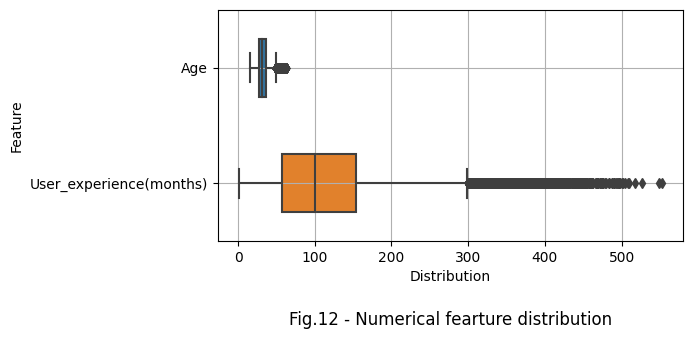

In [126]:
fig = plt.figure(figsize=(6, 3))

boxplot = sns.boxplot(data=data_encoded[['Age', 'User_experience(months)']], orient='h', width=0.5)
boxplot.set_title('Fig.12 - Numerical fearture distribution', y=-0.4, fontsize=12)
boxplot.set_xlabel('Distribution')
boxplot.set_ylabel('Feature')
boxplot.grid();

Let us normalize these features since each of them contains more than 15 unique values.

The 'salary' feature has a large distribution. So it shoud be normalized. 

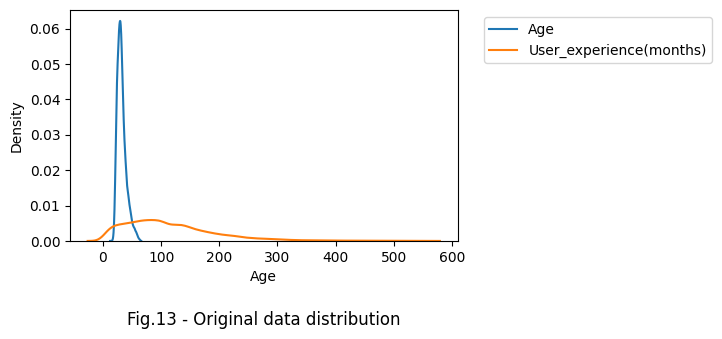

In [127]:
# Visualization of the features distribution
fig, (ax1) = plt.subplots(ncols=1, figsize=(5, 3))
ax1.set_title('Fig.13 - Original data distribution', y=-0.4)

sns.kdeplot(data_encoded['Age'], ax=ax1, label ='Age')
sns.kdeplot(data_encoded['User_experience(months)'], ax=ax1, label ='User_experience(months)')
ax1.legend(bbox_to_anchor=(1.05, 1), loc='upper left');
#sns.kdeplot(data_encoded['salary(rub)'], ax=ax1, label ='salary(rub)')

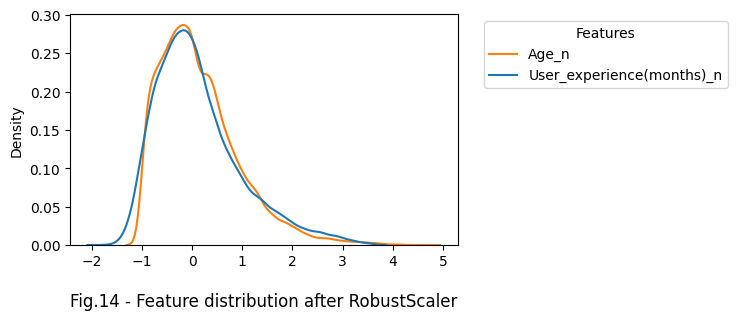

In [128]:
# Initiate the RobustScaler()
r_scaler = preprocessing.RobustScaler()

# copy original dataset
df_r = r_scaler.fit_transform(data_encoded[['Age', 'User_experience(months)']]) #'salary(rub)'

#Transform the features for visualization
df_r = pd.DataFrame(df_r, columns=['Age_n', 'User_experience(months)_n']) #'salary(rub)'

# Add transformed features to the Dataframe
data_encoded = data_encoded.join(df_r, how='left') #on='mukey'

# Delere original features without normalization
data_encoded.drop(['Age', 'User_experience(months)'], axis=1, inplace=True)

# Plot the features
fig, (ax2) = plt.subplots(ncols=1, figsize=(5, 3))
sns.kdeplot(df_r, ax=ax2)
ax2.set_title('Fig.14 - Feature distribution after RobustScaler', y=-0.3)
ax2.legend(df_r, title='Features', bbox_to_anchor=(1.05, 1), loc='upper left');

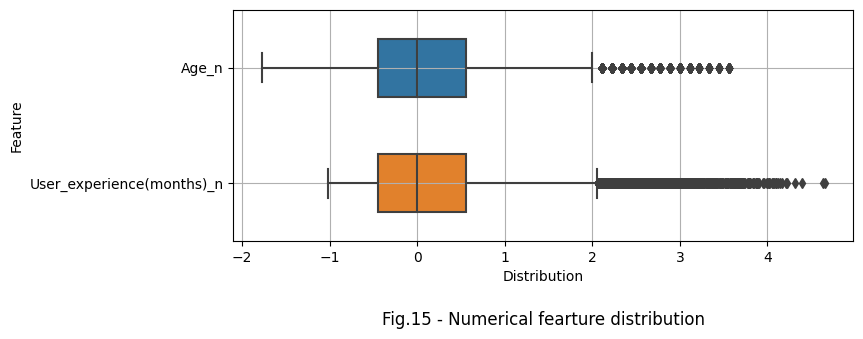

In [129]:
fig = plt.figure(figsize=(8, 3))

boxplot = sns.boxplot(data=data_encoded[['Age_n', 'User_experience(months)_n']], orient='h', width=0.5)
boxplot.set_title('Fig.15 - Numerical fearture distribution', y=-0.4, fontsize=12)
boxplot.set_xlabel('Distribution')
boxplot.set_ylabel('Feature')
boxplot.grid();

### Check missed data

In [130]:
# Percent of missed values by rows
cols_null_percent = round(data_encoded.isnull().mean() * 100, 2)
cols_with_null = cols_null_percent[cols_null_percent > 0].sort_values(ascending=False)
print(f"Features with missed values, %: \n{cols_with_null}")

Features with missed values, %: 
Age_n                        0.76
User_experience(months)_n    0.76
dtype: float64


In [139]:
# Delete rows with missed data
data_encoded = data_encoded.dropna(how='any', axis=0)

#отображаем результирующую долю пропусков
display(data_encoded.isnull().mean().head())

# copy dataframe
data_prepared = data_encoded.copy()

salary(rub)                    0.0
auto                           0.0
Education_higher               0.0
Education_higher_unfinished    0.0
Education_secondary            0.0
dtype: float64

In [140]:
data_prepared.head(1)

,salary(rub),auto,Education_higher,Education_higher_unfinished,Education_secondary,Education_secondary_professional,Gender_F,Gender_M,City_Moscow,City_Petersburg,...,remote_False,remote_True,daily_shifts_False,daily_shifts_True,long_shifts_False,long_shifts_True,Relocation_False,Relocation_True,Age_n,User_experience(months)_n
0,29000.0,1,0,1,0,0,0,1,0,0,...,0,1,0,1,0,1,1,0,0.888889,1.051546


## Models 

### Linear models and Ordinary least squares (OLS)

In [141]:
# Create two matrixes: features and target
X, y = data_prepared.drop('salary(rub)', axis=1, ), data_prepared['salary(rub)']

# Split the data in a ratio 80/20
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=RANDOM_SEED)

# check the shape
print(f'X_Train: {X_train.shape} y_train: {y_train.shape}')
print(f' X_Test: {X_test.shape},  y_test: {y_test.shape}')

X_Train: (35252, 61) y_train: (35252,)
 X_Test: (8814, 61),  y_test: (8814,)


In [144]:
# Define metrics
def print_metrics(y_train, y_train_predict, y_test, y_test_predict):
    print('Train R^2: {:.3f}'.format(metrics.r2_score(y_train, y_train_predict)))
    print('Train MAE: {:.0f} rub.'.format(metrics.mean_absolute_error(y_train, y_train_predict)))
    print('Train MAPE: {:.0f} %'.format(metrics.mean_absolute_percentage_error(y_train, y_train_predict)*100))
    print('\n')
    print('Test R^2: {:.3f}'.format(metrics.r2_score(y_test, y_test_predict)))
    print('Test MAE: {:.0f} rub.'.format(metrics.mean_absolute_error(y_test, y_test_predict)))
    print('Train MAPE: {:.0f} %'.format(metrics.mean_absolute_percentage_error(y_test, y_test_predict)*100))

In [145]:
#Creation an instance of the LinearRegression class
lr_model = linear_model.LinearRegression()

# Train the Model
lr_model.fit(X_train, y_train)
 
# Prediction for train data
y_train_predict = lr_model.predict(X_train)

# Prediction for validation data
y_test_predict = lr_model.predict(X_test)

# Calculation of metrics for both samples
print_metrics(y_train, y_train_predict, y_test, y_test_predict)

Train R^2: 0.380
Train MAE: 31539 rub.
Train MAPE: 58 %


Test R^2: 0.369
Test MAE: 31962 rub.
Train MAPE: 61 %


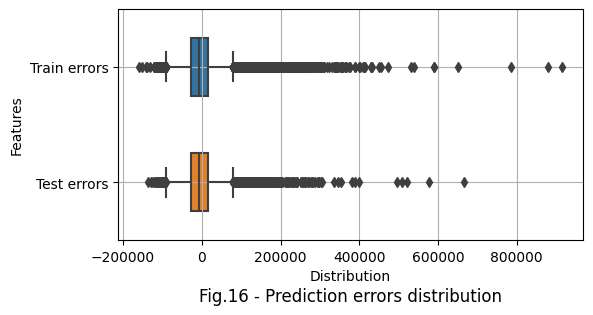

In [146]:
A , B = y_train - y_train_predict, y_test - y_test_predict

# Creation of a new DataFrame using train and test errors for visualization
error_df = pd.DataFrame(
    {'Train errors': A, 
     'Test errors': B
    }
)

fig = plt.figure(figsize=(6, 3))

fig = sns.boxplot(
    data=error_df,
    #y='client status',
    #x='Balance',
    orient='h',
    width=0.5
)
fig.set_title('Fig.16 - Prediction errors distribution', y=-.3, fontsize=12)
fig.set_xlabel('Distribution')
fig.set_ylabel('Features')
#fig.set(xscale="log")
fig.grid();

## Random forest

In [147]:
from sklearn.ensemble import RandomForestRegressor 

# Create the model
model = RandomForestRegressor(n_estimators=150, verbose=0, n_jobs=-1,  random_state=RANDOM_SEED)

# Learn the model
model.fit(X_train, y_train)

# Predict the data
y_train_pred_rforest = model.predict(X_train)
y_test_pred_rforest = model.predict(X_test)

# Calculation of metrics for both samples
print_metrics(y_train, y_train_pred_rforest, y_test, y_test_pred_rforest)

Train R^2: 0.904
Train MAE: 11873 rub.
Train MAPE: 21 %


Test R^2: 0.301
Test MAE: 32422 rub.
Train MAPE: 60 %


## 2th iteration: Polynominal regression

In [148]:
# Create a generator of polynominal features
poly = preprocessing.PolynomialFeatures(degree=2, include_bias=False)
poly.fit(X_train)
# Generation of polynominal features for tain and test samples
X_train_scaled_poly = poly.transform(X_train)
X_test_scaled_poly = poly.transform(X_test)
# Display shapes
print(X_train_scaled_poly.shape)
print(X_test_scaled_poly.shape)

(35252, 1952)
(8814, 1952)


In [149]:
# Creation of an isntance of the linear model class 
lr_model_poly = linear_model.LinearRegression()

# Learn the model using OLS method
lr_model_poly.fit(X_train_scaled_poly, y_train)

# Prediction for both: train and test samples
y_train_predict_poly = lr_model_poly.predict(X_train_scaled_poly)
y_test_predict_poly = lr_model_poly.predict(X_test_scaled_poly)

#Calculation of metrics
print_metrics(y_train, y_train_predict_poly, y_test, y_test_predict_poly)

Train R^2: 0.434
Train MAE: 29316 rub.
Train MAPE: 52 %


Test R^2: 0.410
Test MAE: 30189 rub.
Train MAPE: 56 %


In [150]:
print(np.round(lr_model_poly.coef_, 2))

[ 2.63994270e+15  3.54309034e+15 -5.63732132e+15 ...  1.96000000e+02
 -3.12000000e+02  5.44000000e+02]


High values of the model coefficients indicates that the model needs regularization.

### L1 Regularization

Before we apply L1 regularization, we need to standardize our data.

In [151]:
# Initialization of the MinMaxScaler lib
scaler = preprocessing.MinMaxScaler()  #StandardScaler()
# Train the model
scaler.fit(X_train)
# Transform each sample's features 
X_train_scaled = scaler.transform(X_train)
X_test_scaled = scaler.transform(X_test)

Create the model

In [152]:
#Create a generator of polynominal features
poly = preprocessing.PolynomialFeatures(degree=2, include_bias=False)
poly.fit(X_train_scaled)
# Generation of polynom. features for tain and test samples
X_train_scaled_poly = poly.transform(X_train_scaled)
X_test_scaled_poly = poly.transform(X_test_scaled)

# Create a generator of polynominal features
poly = preprocessing.PolynomialFeatures(degree=2, include_bias=False)
poly.fit(X_train_scaled)
# Generation of polynominal features for tain and test samples
X_train_scaled_poly = poly.transform(X_train_scaled)
X_test_scaled_poly = poly.transform(X_test_scaled)
# Display shapes
print(X_train_scaled_poly.shape, X_test_scaled_poly.shape)

(35252, 1952) (8814, 1952)


In [153]:
# Creation of an isntance of the linear model class wtith the L1-regularization.
lasso_lr_poly = linear_model.Lasso(alpha=0.1, max_iter=100) 
# Train the model
lasso_lr_poly.fit(X_train_scaled_poly, y_train)
# Prediction for train and test samples
y_train_predict_poly = lasso_lr_poly.predict(X_train_scaled_poly)
y_test_predict_poly = lasso_lr_poly.predict(X_test_scaled_poly)
# Calculation of metrics
print_metrics(y_train, y_train_predict_poly, y_test, y_test_predict_poly)

Train R^2: 0.435
Train MAE: 29133 rub.
Train MAPE: 51 %


Test R^2: 0.410
Test MAE: 30007 rub.
Train MAPE: 55 %


C:\Users\Lena\AppData\Roaming\Python\Python310\site-packages\sklearn\linear_model\_coordinate_descent.py:631: ConvergenceWarning:

Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.149e+13, tolerance: 1.293e+10



In [154]:
print(np.round(lasso_lr_poly.coef_, 2))

[ 7244.19 29858.87 10957.76 ...  1187.11  -999.6  14720.13]


The model does not converge engn though coefficients have become much lower. Let us apply L2 regularization method.

### L2-regularization

In [155]:
# Creation of an isntance of the linear model class wtith the L2-regularization.
ridge_lr_poly = linear_model.Ridge(alpha=10)
# Train the model
ridge_lr_poly.fit(X_train_scaled_poly, y_train)
# Make a prediction for train and test samples
y_train_predict_poly = ridge_lr_poly.predict(X_train_scaled_poly)
y_test_predict_poly = ridge_lr_poly.predict(X_test_scaled_poly)
#Display the metrics
print_metrics(y_train, y_train_predict_poly, y_test, y_test_predict_poly)

Train R^2: 0.435
Train MAE: 29116 rub.
Train MAPE: 51 %


Test R^2: 0.411
Test MAE: 29950 rub.
Train MAPE: 55 %


In [156]:
print(np.round(ridge_lr_poly.coef_, 2))

[ 351.8   672.27 -357.62 ... 2852.15 2474.26 7966.99]


Finally, we have got a better result which can be compared with that of the linear model:

```
Test R^2: 0.413
Test MAE: 29772 rub.
Train MAPE: 53 %
```

### Find the best coefficient value for L2-regularization

In [157]:
# Get a logarythm of train data
y_train_log = np.log(y_train)

# Creation an instance of the LinearRegression class
lr = linear_model.LinearRegression()
# Train the Model
lr.fit(X_train, y_train_log)
#Prediction and get expanential data
y_train_pred = np.exp(lr.predict(X_train))
y_test_pred = np.exp(lr.predict(X_test))
# Get metrics
print_metrics(y_train, y_train_pred, y_test, y_test_pred)

Train R^2: 0.370
Train MAE: 28476 rub.
Train MAPE: 44 %


Test R^2: 0.357
Test MAE: 28940 rub.
Train MAPE: 47 %


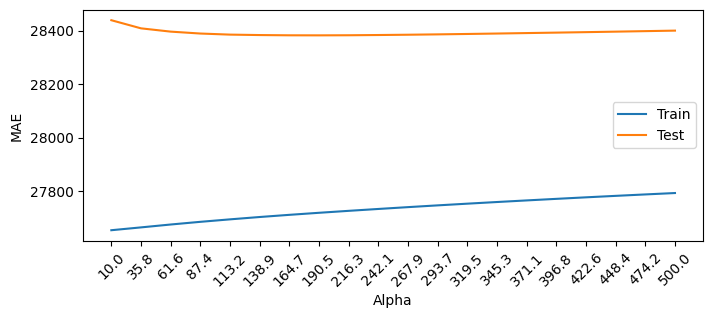

In [158]:
# Create 20 values of alpha between 10 and 500
alpha_list = np.linspace(10, 500, 20)
# Empty lists to store results
train_scores = []
test_scores = []
for alpha in alpha_list:
    # Creation of an isntance of the linear model class wtith the L2-regularization.
    ridge_lr_poly = linear_model.Ridge(alpha=alpha, max_iter=100)
    #Train the model
    ridge_lr_poly.fit(X_train_scaled_poly, y_train_log)
    #Get the prediction
    y_train_predict_poly = np.exp(ridge_lr_poly.predict(X_train_scaled_poly))
    y_test_predict_poly = np.exp(ridge_lr_poly.predict(X_test_scaled_poly))
    # Metrics
    train_scores.append(metrics.mean_absolute_error(y_train, y_train_predict_poly))
    test_scores.append(metrics.mean_absolute_error(y_test, y_test_predict_poly))

# Visualization of the prediction errors
fig, ax = plt.subplots(figsize=(8, 3)) 
ax.plot(alpha_list, train_scores, label='Train')
ax.plot(alpha_list, test_scores, label='Test')
ax.set_xlabel('Alpha') # x axis label
ax.set_ylabel('MAE') # y axis label
ax.set_xticks(alpha_list) # axis ticks
ax.xaxis.set_tick_params(rotation=45)  
ax1.set_title('Fig.17 - Model learning errors', y=-0.2)
ax.legend();

Let us calculate the lowest point of the test curve.

In [230]:
# return the index of the minimal value
min_index = np.argmin(test_scores)
print(f'\nMin index: {min_index}')

print(f'Best alpha value is: {alpha_list[min_index].round()}')


Min index: 7
Best alpha value is: 191.0


Best model has alpha ~ 190

In [227]:
# Creation of an isntance of the linear model class wtith the L2-regularization with the best alpha-coefficient
ridge_lr = linear_model.Ridge(alpha=190)
# Train the model to predict log target values
ridge_lr.fit(X_train_scaled_poly, y_train_log)
#Make a prediction for train and test samples and get expanential data
y_train_pred = np.exp(ridge_lr.predict(X_train_scaled_poly))
y_test_pred = np.exp(ridge_lr.predict(X_test_scaled_poly))
# Calculate metrics
print_metrics(y_train, y_train_pred, y_test, y_test_pred)

Train R^2: 0.400
Train MAE: 27719 rub.
Train MAPE: 42 %


Test R^2: 0.383
Test MAE: 28383 rub.
Train MAPE: 45 %


In [162]:
print(np.round(ridge_lr.coef_, 2))

[ 0.    0.01 -0.   ...  0.02  0.01  0.01]


# Conclusion

It was created a model, predicting user's salary value by user data features.